# Neural Networks for Data Science Applications (2019/2020)
## Final exam

* **Student(s)**: Francesco Russo (1449025), Iason Tsardanidis (1846834), Michele Cernigliaro (1869097)
* **Reference paper / topic**: Hu, Xiaodan, et al. "RUNet: A Robust UNet Architecture for Image Super-Resolution." Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition Workshops. 2019.

## Part 1: Report

##### 1.1) Robust UNet Architecture for Image Super-Resolution

In this project we faced the so called *Single Image Super-Resolution* (SISR) problem, which aims to infer High-Resolution (HR) images from Low-Resolution (LR) ones. The approach used by Hu, Xiaodan et al. in [1] is to exploit the U-Net network used for segmentation tasks introduced by Ronneberger et al. in [2], ending up in a network which is capable to enhance image quality. The network is shown in the image below. 


![Robust-UNet architecture](https://raw.githubusercontent.com/cerniello/Super_Resolution_DNN/master/img/00_RUnet.png)

It consists in two main parts: a **downsampling part**, composed by a series of blocks made up with convolutional layers, batch normalization and ReLU activation functions, and an **upsampling part**, where sub-pixel convolutional layers are used in order up-scale from low-resolution. After each upsampling, a concatenation is performed. Unlike in U-Net, in RUnet we notice the presence of residual blocks in the downsampling part which as suggested in [1] "allows the network to learn more complex structure". In conclusion, in contrast to any of the common Super-Resolution network architectures, the dimensions of the input and the output images coincide during the training phase.

#### Some interesting artifacts

##### 1.1) Pixel Shuffle

![Robust-UNet architecture](https://raw.githubusercontent.com/cerniello/Super_Resolution_DNN/master/img/pixel_shuffle.jpeg)

It is about a specific type of image reshaping in order to increase the resolution of the already *down-scaled* image. Preceded by a convolution layer, all together compose a **sub-pixel** layer. It is a *state-of-the-art* technique and very famous in SR tasks, since unlikely to ordinary upsampling layers, instead of putting zeros in between pixels and having to do extra computation, they calculate more convolutions in lower resolution and resize the resulting map combining existed filters into an upscaled image in order to avoid redundant zeros between layers. For more information check [3]. 


##### 1.2) Perceptual loss, metrics

For the training of this network we will implement the **perceptual loss** as suggested in our reference paper. Perceptual loss implementation is a very innovative strategy for SR problems (see also [4]). It is about a metric distance provided from pre-trained CNN layers between the output and the target image:

$$ L^j = \frac{1}{C^j H^j W^j}{||\phi_j(Ground Truth) - \phi_j(Predicted Image)||}^2_2$$


where $C_j × H_j × W_j$ denotes the size of feature map ($\phi_j$) obtained at the j th convolutional layer. 

We decided to use VGG net pretrained on *imagenet* dataset. Moreover for the evaluation of our results we will apply some metrics related to *image evaluation*:

- **MSE (Mean-Squared-Error)**

- **PSNR (Peak signal-to-noise ratio)**: An engineering term for the ratio between the maximum possible power of a signal and the power of corrupting noise that affects the fidelity of its representation (usually expressed in lagarithmic scale).

- **SSIM (Structural Similarity)**: A perception-based model (not estimates absolute errors) that considers image degradation as perceived change in structural information.

##### 1.3) Dataset

To train our network we took some pictures from Linnaeus 5 dataset [5]. The dataset is offered for multi-class classification between 5 labels (berry, bird, dog, flower, other) and it has 6000 colored images as training set and 2000 as test set. The nice thing of Linnaeus 5 is that the autors provides the images in different formats: 256x256 pixels and 128X128, 64X64 and 32X32 pixels as downsampled versions.

We decided to take 2000 128x128 pixels images in order to train our dataset. We splitted it in training (85%) and validation set (15%). For the testing phase, we used 64x64 pixels images to be enhanced with our RUnet. Then we compared the results with the relative 128x128 pixels images of the test set (see part 4).


##### 1.4) Implementation

We implemented the network in python using **tensorflow v2.1** and **Keras API**. We worked on **Colaboratory** in order to take advantage of the available GPU units and speed up the computation. See part 2 to see the external libraries used in the project.
        
In our convolution blocks we used the same kernel size (3,3) proposed in [1]. Instead of using mirroring as done i.e. with UNet we used zero padding in order to preserve the same dimension after each convolution. 

In some residual connections we rescaled the input by means of 1x1 convolutive block. 


## Part 2: External libraries

In [1]:
# Set up for Colab: tf2.1 and PyDrive to download the dataset

# installing tensorflow 2.1
!pip install --quiet tensorflow-gpu==2.1.0

# After this, restart the runtime to avoid authentication issues
!pip install -q -U PyDrive

     |████████████████████████████████| 421.8MB 39kB/s 
     |████████████████████████████████| 3.8MB 45.8MB/s 
     |████████████████████████████████| 450kB 62.6MB/s 
     |████████████████████████████████| 81kB 13.5MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.1.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorboard 2.1.0 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.11.0 which is incompatible.


In [0]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
# Linnaeus_5 dataset from a Google Drive:
file_id = '1hYf6wlpO0Kp0y_btm2PKmWmpX4Gpqkg3'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('Linnaeus_5.zip')

!ls
!unzip -q Linnaeus_5.zip
!ls Linnaeus_5

adc.json  Linnaeus_5.zip  sample_data
test_128  test_64  train_128


In [0]:
import os                       # pkg to read filepaths from the dataset folder
import tensorflow as tf         # tensorflow
import tensorflow.keras as K    # keras API
import numpy as np              # numpy to work with tensors (with tf)
import matplotlib.pyplot as plt # function to show images
%matplotlib inline              
import cv2                      # pkg to load image as np.array

# vgg net for perceptual loss
from tensorflow.keras.applications.vgg19 import VGG19

## Part 3: Code


In [0]:
# defining the image input and our batch size
input_size = 128 # 128x128x3 images
batch_size= 16 

In [3]:
# Perceptual loss function 

# load pre-trained (imagenet) vgg network, excluding fully-connected layer on the top
vgg = VGG19(include_top=False, weights='imagenet', input_shape=(None,None,3))
vgg_layer = K.Model(inputs=vgg.input, outputs=vgg.get_layer('block2_conv2').output)
# make the net not trainable
for l in vgg_layer.layers: l.trainable=False 

print(vgg_layer.summary())

def perceptual_loss(y_true,y_pred):
    '''This function computes the perceptual loss using an already trained VGG layer'''
    y_t=vgg_layer(y_true)
    y_p=vgg_layer(y_pred)
    loss=K.losses.mean_squared_error(y_t,y_p)
    loss = loss/(3*input_size*input_size) # dividing with the size of the output feature map
    return loss

80142336/80134624 [==============================] - 8s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
Total params: 260,160
Trainable params: 0
Non-trainable params

In [4]:
print('kernel size:', vgg_layer.get_layer(index=-1).kernel_size) #size of the output kernel

kernel size: (3, 3)


In [0]:
# defining other metrics:
def psnr(y_true,y_pred):
    return tf.image.psnr(y_true,y_pred,1.0)
def ssim(y_true,y_pred):
    return tf.image.ssim(y_true,y_pred,1.0)

In [0]:
def image_proc_net(training_mode=True):
    """
    Function which creates the model to preprocess images.
    2 different types of model with different layers depending
    on whether it is in training mode or in testing mode
    """
    inputs = K.layers.Input((None, None, 3))
    if training_mode:
        # training mode: downsampling, gaussian noise and upsampling
        x = K.layers.MaxPool2D(pool_size=(2,2))(inputs)
        x = K.layers.GaussianNoise(5)(x)
        x = K.layers.UpSampling2D((2,2))(x)
    else:
        # testing mode: just an upsampling
        x = K.layers.UpSampling2D((2,2))(inputs)

    model = K.models.Model(inputs, x)

    for l in model.layers: l.trainable=False

    return model

# istantiating the two models (for train and test)
image_proc_train = image_proc_net(training_mode=True)
image_proc_test = image_proc_net(training_mode=False)

In [7]:
#training_mode
print(image_proc_train.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 3)     0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, None, None, 3)     0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, None, None, 3)     0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
#testing_mode
print(image_proc_test.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, None, None, 3)     0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
def image_preprocess(image, training_mode=True):
    """
    Function which preprocess automatically an image
    wether it's in training or testing mode

    input: 
      - image: np array (image tensor)
      - training_mode: binary flag
    """
    image = np.expand_dims(image,axis=0)
    if training_mode:
        return tf.squeeze(image_proc_train(image))
    else:
        return tf.squeeze(image_proc_test(image))

In [0]:
# reading image 
def read_image(img_path):
  """
  function which loads an image from a path and convert it into np array
  """
  img = cv2.imread(img_path)
  b,g,r = cv2.split(img)   # cv2 reads BGR instead of canonical RGB
  img = cv2.merge([r,g,b]) # Switching it to RGB

  return img


In [11]:
# creating train, validation and test lists containing the image paths

all_images = [] # all train image paths

train_list = [] # train image paths list after train-validation split
val_list = []   # val   image paths list after train-validation split

# 128x128 in training phase
path = 'Linnaeus_5/train_128'
 
files = os.listdir(path)
for file in files:
    path_file = path+'/'+file
    for (dirpath, dirnames, filenames) in os.walk(path_file):
        filenames = list(map(lambda x:path_file+'/'+x,filenames))
        all_images.extend(filenames)


all_images = all_images[:2000] # picking only 2000 over 6000 images
np.random.shuffle(all_images)  # random shuffling

# keep 85% for train and 15% for validation
train_len = int(len(all_images)*0.85)

train_list = all_images[:train_len]
val_list = all_images[train_len:]


# test
# for the test set we opted to take the same dataset
# but with images of size 64x64 instead of 128x128

test_list = []

path = 'Linnaeus_5/test_64'
files = os.listdir(path)
for file in files:
    path_file = path+'/'+file
    for (dirpath, dirnames, filenames) in os.walk(path_file):
        filenames = list(map(lambda x:path_file+'/'+x,filenames))
        test_list.extend(filenames)

np.random.shuffle(test_list) # random shuffling

test_list = test_list[:500]

print('images: ')
print('train:', len(train_list), 'val:', len(val_list), 'test:', len(test_list))

images: 
train: 1700 val: 300 test: 500


In [0]:
# defining train, validation and test generator

def train_generator():
    global batch_size
    while True:
        for start in range(0, len(train_list), batch_size):
                    x_batch = []
                    y_batch = []
                    end = min(start + batch_size, len(train_list))
                    ids_train_batch = train_list[start:end]
                    for i,ids in enumerate(ids_train_batch):
                        img_y = read_image(ids)
                        img_x = image_preprocess(img_y, training_mode=True)
                        x_batch.append(np.array(img_x,np.float32)/255.)
                        y_batch.append(np.array(img_y,np.float32)/255.)
                    x_batch = np.array(x_batch)
                    y_batch = np.array(y_batch)
                    yield x_batch,y_batch
                    
def valid_generator():
    global batch_size
    while True:
        for start in range(0, len(val_list), batch_size):
                    x_batch = []
                    y_batch = []
                    end = min(start + batch_size, len(val_list))
                    ids_val_batch = val_list[start:end]
                    for i,ids in enumerate(ids_val_batch):
                        img_y = read_image(ids)
                        img_x = image_preprocess(img_y, training_mode=True)
                        x_batch.append(np.array(img_x,np.float32)/255.)
                        y_batch.append(np.array(img_y,np.float32)/255.)
                    x_batch = np.array(x_batch)
                    y_batch = np.array(y_batch)
                    yield x_batch,y_batch


def test_generator():
    global batch_size
    while True:
        for start in range(0, len(test_list), batch_size):
                    x_batch = []
                    y_batch = []
                    end = min(start + batch_size, len(test_list))
                    ids_test_batch = test_list[start:end]
                    for i,ids in enumerate(ids_test_batch):
                        img_y = read_image(ids)
                        img_x = image_preprocess(img_y, training_mode=False)
                        x_batch.append(np.array(img_x,np.float32)/255.)
                        y_batch.append(np.array(img_y,np.float32)/255.)
                    x_batch = np.array(x_batch)
                    y_batch = np.array(y_batch)
                    yield x_batch,y_batch

In [0]:
# pixel shuffle 
def pixel_shuffle(scale):
    '''
    This function implements pixel shuffling.
    ATTENTION: the scale should be bigger than 2, otherwise just returns the input.
    '''
    if scale > 1:
        return lambda x: tf.nn.depth_to_space(x, scale)
    else:
        return lambda x:x

In [0]:
#blocks definition for upscaling/downscaling

def add_down_block(x_inp, filters, kernel_size=(3, 3), padding="same", strides=1,r=False):
    x = K.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x_inp)
    x = K.layers.BatchNormalization()(x)
    x = K.layers.Activation('relu')(x)
    x = K.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    x = K.layers.BatchNormalization()(x)
    if r:
        # if r=True then we import an (1X1) Conv2D after input layer 
        # in order the dimensions of 2 tensors coincide.
        x_inp = K.layers.Conv2D(filters,(1,1), padding=padding, strides=strides)(x_inp)
    x = K.layers.Add()([x,x_inp])
    return x

def add_up_block(x_inp,skip,filters, kernel_size=(3, 3), padding="same", strides=1,upscale_factor=2):
    x = pixel_shuffle(scale=upscale_factor)(x_inp)
    x = K.layers.Concatenate()([x, skip])
    x = K.layers.BatchNormalization()(x)
    x = K.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    x = K.layers.Activation('relu')(x)
    x = K.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    x = K.layers.Activation('relu')(x)
    x = K.layers.Activation('relu')(x)
    return x

def add_bottleneck(x_inp,filters, kernel_size=(3, 3), padding="same", strides=1):
    x = K.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x_inp)
    x = K.layers.Activation('relu')(x)
    return x

In [15]:
def RUNet():
    """
      Implementing with Keras the Robust UNet Architecture as proposed by
      Xiaodan Hu, Mohamed A. Naiel, Alexander Wong, Mark Lamm, Paul Fieguth
      in "RUNet: A Robust UNet Architecture for Image Super-Resolution"
    """
    inputs = K.layers.Input((input_size,input_size, 3))
    
    
    down_1 = K.layers.Conv2D(64,(7,7), padding="same", strides=1)(inputs)
    down_1 = K.layers.BatchNormalization()(down_1)
    down_1 = K.layers.Activation('relu')(down_1)
    
    down_2 = K.layers.MaxPool2D(pool_size=(2,2))(down_1)
    down_2 = add_down_block(down_2,64)
    down_2 = add_down_block(down_2,64)
    down_2 = add_down_block(down_2,64)
    down_2 = add_down_block(down_2,128,r=True)
    
    down_3 = K.layers.MaxPool2D(pool_size=(2, 2),strides=2)(down_2)
    down_3 = add_down_block(down_3,128)
    down_3 = add_down_block(down_3,128)
    down_3 = add_down_block(down_3,128)
    down_3 = add_down_block(down_3,256,r=True)
    
    down_4 = K.layers.MaxPool2D(pool_size=(2, 2))(down_3)
    down_4 = add_down_block(down_4,256)
    down_4 = add_down_block(down_4,256)
    down_4 = add_down_block(down_4,256)
    down_4 = add_down_block(down_4,256)
    down_4 = add_down_block(down_4,512,r=True) 
    
    down_5 = K.layers.MaxPool2D(pool_size=(2, 2))(down_4)
    down_5 = add_down_block(down_5,512)
    down_5 = add_down_block(down_5,512)
    down_5 = K.layers.BatchNormalization()(down_5)
    down_5 = K.layers.Activation('relu')(down_5)
    
    
    bn_1 = add_bottleneck(down_5, 1024)
    bn_2 = add_bottleneck(bn_1, 512)
    
    up_1 = add_up_block(bn_2,down_5, 512,upscale_factor=1)
    up_2 = add_up_block(up_1,down_4, 384,upscale_factor=2)
    up_3 = add_up_block(up_2,down_3, 256,upscale_factor=2)
    up_4 = add_up_block(up_3,down_2, 96,upscale_factor=2) 
    
    up_5 = pixel_shuffle(scale=2)(up_4)
    up_5 = K.layers.Concatenate()([up_5,down_1])
    up_5 = K.layers.Conv2D(99,(3,3), padding="same", strides=1)(up_5)
    up_5 = K.layers.Activation('relu')(up_5)
    up_5 = K.layers.Conv2D(99,(3,3), padding="same", strides=1)(up_5)
    up_5 = K.layers.Activation('relu')(up_5)
   
    outputs = K.layers.Conv2D(3,(1,1), padding="same")(up_5)
    model = K.models.Model(inputs, outputs)
    return model

model = RUNet()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 9472        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [16]:
opt=K.optimizers.Adam(learning_rate=0.001) # Adam optimizer
model.compile(optimizer=opt,loss=perceptual_loss,metrics=[psnr,ssim,K.losses.mean_squared_error])
history = model.fit_generator(generator=train_generator(),
                              steps_per_epoch=np.ceil(float(len(train_list)) / float(batch_size)),
                              epochs=20,
                              verbose=1,
                              validation_data=valid_generator(),
                              shuffle=True,
                              validation_steps=np.ceil(float(len(val_list)) / float(batch_size)))

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 107.0 steps, validate for 19.0 steps
Epoch 1/20
107/107 [==============================] - 65s 604ms/step - loss: 4.3337e-05 - psnr: 13.6535 - ssim: 0.3261 - mean_squared_error: 0.0591 - val_loss: 1.1463e-04 - val_psnr: 11.1053 - val_ssim: 0.2617 - val_mean_squared_error: 0.0909
Epoch 2/20
107/107 [==============================] - 41s 381ms/step - loss: 2.7311e-05 - psnr: 19.3167 - ssim: 0.5563 - mean_squared_error: 0.0131 - val_loss: 9.4209e-05 - val_psnr: 13.2069 - val_ssim: 0.3270 - val_mean_squared_error: 0.0549
Epoch 3/20
107/107 [==============================] - 42s 394ms/step - loss: 2.5431e-05 - psnr: 20.4083 - ssim: 0.5969 - mean_squared_error: 0.0102 - val_loss: 6.6741e-05 - val_psnr: 14.9818 - val_ssim: 0.4120 - val_mean_squared_error: 0.0356
Epoch 4/20
107/107 [==============================] - 42s 388ms/step - loss: 2.4458e-05 - psnr: 20

## Part 4 - Experimental evaluation

#### Metrics: history

We show in the following part the results in term of metrics during the training epochs.

In [0]:
def history_results(history, par1='loss', par2='val_loss', title='loss'):
    """
    Plot the history of the the 2 metrics (par1, par2) during 
    the training (epochs)
    """
    plt.plot(history.history[par1])
    plt.plot(history.history[par2])
    plt.title(title)
    plt.ylabel(par1)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.grid()
    plt.show()

    return

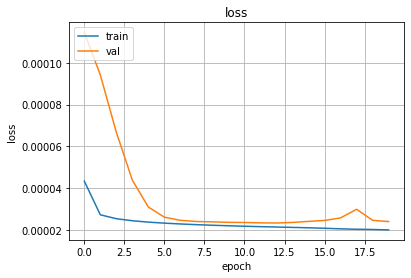

In [18]:
history_results(history)

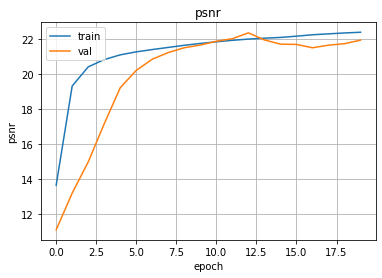

In [19]:
history_results(history, 'psnr', 'val_psnr', 'psnr')

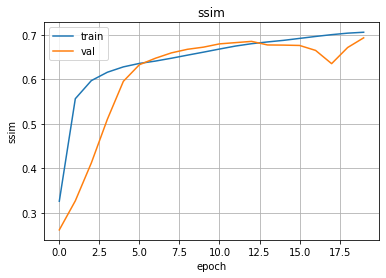

In [20]:
history_results(history, 'ssim', 'val_ssim', 'ssim')

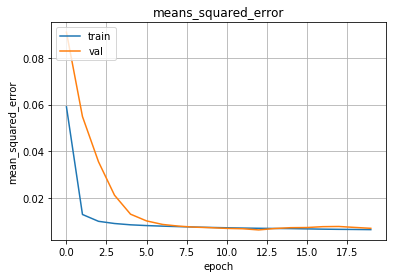

In [21]:
history_results(history, 'mean_squared_error', 'val_mean_squared_error', 'means_squared_error')

#### Showing some visual results of Super-Resolution

In testing mode, 64x64 pixels images are used and then the result it's compared with 128x128 pixels images.

In [0]:
def show_pictures(img_idx, x_batch, y_batch):
    """
    Function which shows 3 images:
    - Ground truth: High Resolution image
    - Low Resolution image
    - Super Resolution image using our trained model
    """
    fig = plt.figure(figsize=(15,18))

    ax1 = fig.add_subplot(1,3,1)
    im = model(np.expand_dims(x_batch[img_idx],axis=0))
    im = np.squeeze(im)
    #ax1.imshow((abs(im) * 255).astype(np.uint8))
    ax1.imshow(abs(im))
    ax1.set_title('Super Resolution (from LR)')

    ax2 = fig.add_subplot(1,3,2)
    #ax2.imshow(x_batch[img_idx] * 255).astype(np.uint8))
    ax2.imshow(x_batch[img_idx])
    ax2.set_title('Low Resolution')

    ax3 = fig.add_subplot(1,3,3)
    #ax3.imshow((y_batch[img_idx] * 255).astype(np.uint8))
    ax3.imshow(y_batch[img_idx])
    ax3.set_title('Ground truth')

    return

In [0]:
# trying to visualize the results with some training images

batch_size=10
for start in range(0, len(train_list), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(train_list))
            ids_train_batch = train_list[start:end]
            for i,ids in enumerate(ids_train_batch):
                img_y = read_image(ids)
                img_x = image_preprocess(img_y)
                x_batch.append(np.array(img_x,np.float32)/255.)
                y_batch.append(np.array(img_y,np.float32)/255.)
            x_batch = np.array(x_batch)
            y_batch = np.array(y_batch)
            break

In [24]:
x_batch.shape

(10, 128, 128, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


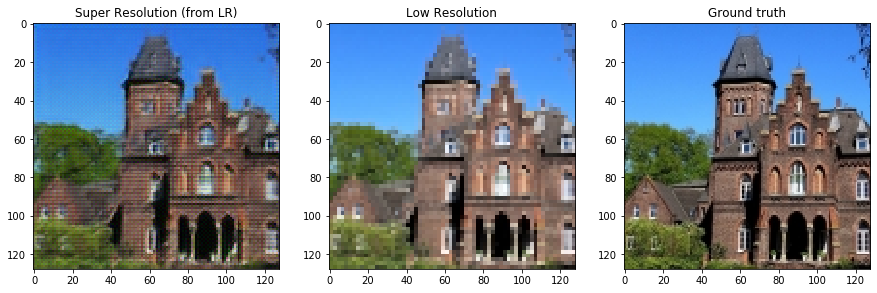

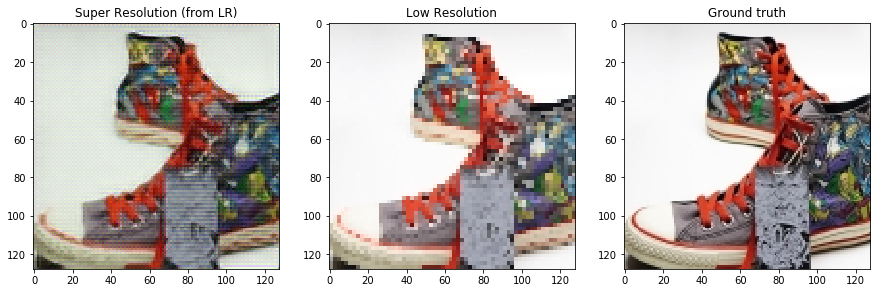

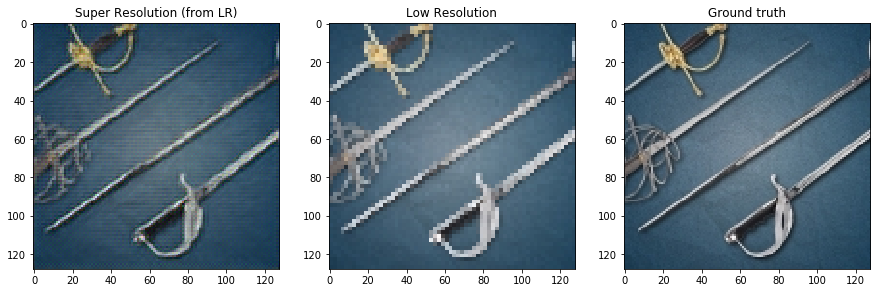

In [25]:
show_pictures(0, x_batch, y_batch)
show_pictures(4, x_batch, y_batch)
show_pictures(9, x_batch, y_batch)

In [0]:
# trying with the Linnaeus_5 test set of 64x64 images
# and comparing the results with their relative HR images (128x128)

batch_size=10
for start in range(0, len(test_list), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(test_list))
            ids_test_batch = test_list[start:end]
            for i,ids in enumerate(ids_test_batch):
                # taking the ids (filepath) of 64x64 img and obtain its 128x128 img
                ids_128 = '128'.join(ids.split('64'))
                img_x = read_image(ids)     # x: 64x64 img
                img_x = image_preprocess(img_x, training_mode=False)
                img_y = read_image(ids_128) # y: 128x128 img 

                x_batch.append(np.array(img_x,np.float32)/255.)
                y_batch.append(np.array(img_y,np.float32)/255.)

            x_batch = np.array(x_batch)
            y_batch = np.array(y_batch)

            break


In [27]:
x_batch.shape

(10, 128, 128, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


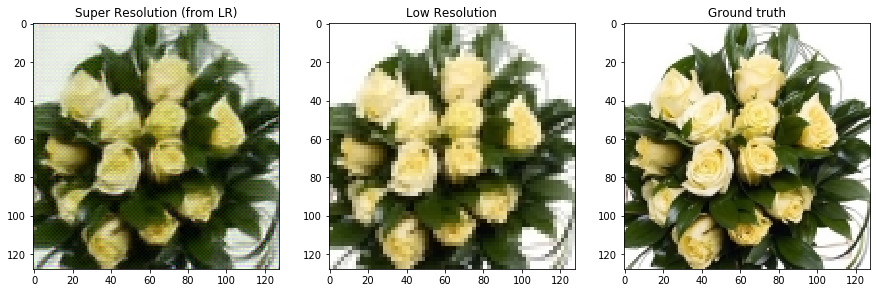

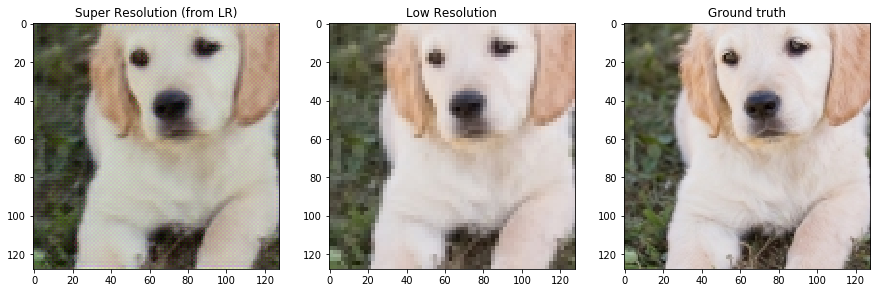

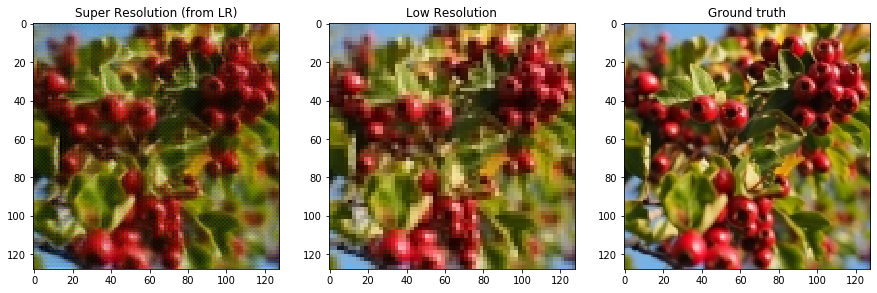

In [28]:
show_pictures(4, x_batch, y_batch)
show_pictures(5, x_batch, y_batch)
show_pictures(9, x_batch, y_batch)

## Conclusions 

#### - Improvements

- Fine tuning:
    - Implement checkpoint callback (with Early stopping)
    - Try perceptual loss with different pre-trained networks (InceptionV3, ResNet)

## References

[1] Hu, Xiaodan, et al. "RUNet: A Robust UNet Architecture for Image Super-Resolution." Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition Workshops. 2019.

[2] Ronneberger, Olaf and Fischer, Philipp and Brox, Thomas. "U-Net: Convolutional Networks for Biomedical Image Segmentation". Medical Image Computing and Computer-Assisted Intervention -- MICCAI 2015.

[3] Wenzhe Shi, Jose Caballero, Ferenc Huszár, Johannes Totz, Andrew P. Aitken, Rob Bishop, Daniel Rueckert, Zehan Wang. "Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network".

[4] Justin Johnson, Alexandre Alahi, Li Fei-Fei. "Perceptual Losses for Real-Time Style Transfer and Super-Resolution".

[5] Chaladze, G. Kalatozishvili L. 2017. Linnaeus 5 Dataset for Machine Learning.